# Traitement des fichiers JSON.

In [0]:
import pandas as pd
import json
from matplotlib.pyplot import *
from pandas.io.json import json_normalize
import dateparser
import numpy as np
import datetime
from datetime import timedelta

On commence par écrire des fonctions intermédaires qui vont permettre de traiter les fichiers json. La première permet d'importer un fichier json dans python.

In [0]:
def importation(file):
    with open(file) as json_data:
        d = json.load(json_data)
    return(d)    

La fonction minute prend en argumment un string de la forme 'hh:ss' et renvoie le nombre de secondes corespondant. Cette fonction va permettre de convertir les colonnes 'duration' des fichiers importés.

In [0]:
def minutes(str_heure) : 
    duree = str_heure.split(':')
    m, s = int(duree[0]), int(duree[1])
    t = timedelta(minutes=m, seconds=s)

    return(t)

La fonction normalize prend en argument un fichier json et l'aplatit en un dataframe contenant : les dates de connections des users, le nombre de pages visitées à chaque connection, et le temps passé en secondes.

In [0]:
def normalize(json): 
    
    json_file =  importation(json)

    act = json_normalize(data = json_file['dates'] , record_path = ['sessions'] , meta = ['date'])              

    act = act.drop(['activities', 'deviceCategory', 'channel'], axis = 1)
    
    l = act.shape[0]
    for i in range(l):
        act.loc[i, 'activitySummary'] = int(act.loc[i, 'activitySummary']['PAGEVIEW'])
        act.loc[i,'date'] = dateparser.parse(act.loc[i,'date'])
        act.loc[i, 'duration'] = minutes(act.loc[i, 'duration']).total_seconds()
    act.rename(columns = {'activitySummary': 'Pageview'}, inplace = True)   
    return(act)

La fonction concat prend en argument une liste de fichier json, leur applique la fonction normalize et concatène les dataframes obtenus.

In [0]:
def concat(file_list):
    
    df = normalize(file_list[0])
    
    for i in range(1, len(file_list)):
        df = pd.concat([df, normalize(file_list[i])])
    
    df = df.sort_values(by = 'date')
    df = df.reset_index(drop = True)
    return(df)
        

La fonction evol_temorelle renvoie l'evolution temporelle du temps passé sur le site et du nombre de pageviews sur le site.

In [0]:
def evol_temorelle(file_list) : 

    data = concat(file_list)
    dates = sorted(np.array(list(set(data['date']))))
    time_spent, pageviews = [], []
    l= len(dates) 
    
    for i in range(0,l): 
        df = data[data['date'].isin([dates[i]])]
        time_spent.append(sum(df['duration']))
        pageviews.append(sum(df['Pageview']))
                   
    plot(dates, time_spent, "--o", color = 'green')
    xlabel('days')
    ylabel('time')
    title('Temps passé sur le site en secondes')
    
    figure()
    plot(dates, pageviews, "--o", color = 'blue' )
    xlabel('days')
    ylabel('pageviews')
    title('Nombre de pages visitées')
    
    show()

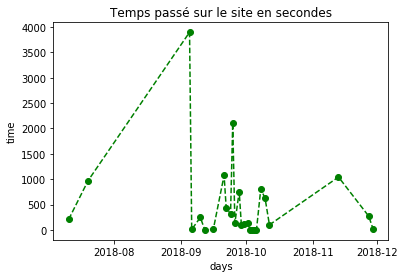

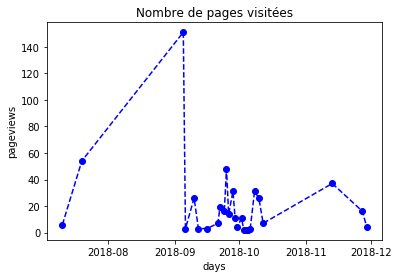

In [0]:
file_list_578 = ['578_1_user-report-export.json', '578_2_user-report-export.json']
evol_temorelle(file_list_578)

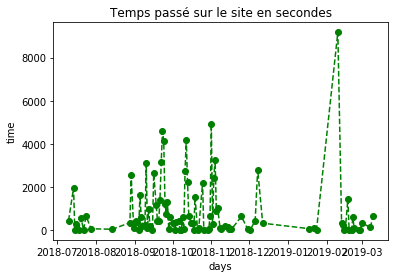

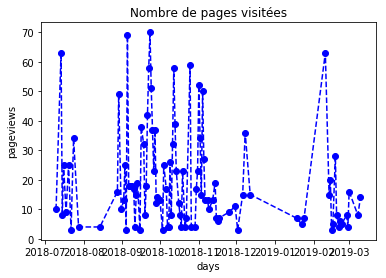

In [0]:
file_list_579 = ['579_1_user-report-export.json', '579_2_user-report-export.json', '579_3_user-report-export.json', '579_4_user-report-export.json']
evol_temorelle(file_list_579)

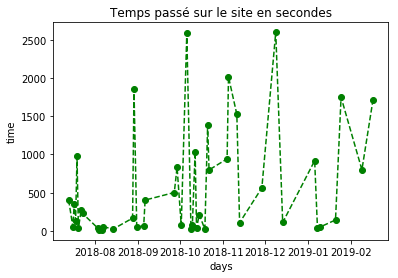

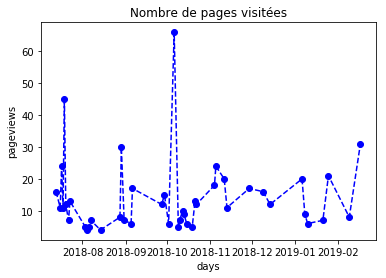

In [0]:
file_list_588 = ['588_1_user-report-export.json', '588_2_user-report-export.json']
evol_temorelle(file_list_588)